# Import the libraries that are necesaries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import getpass  # To get the password without showing the input
from sqlalchemy import create_engine, text
from scipy.stats import pearsonr, spearmanr, ttest_ind

Connect to MySQL

In [2]:
password = getpass.getpass()
user = 'root'
database_name = 'steam_games'
connection_string = f'mysql+pymysql://{user}:' + password + '@localhost/' + database_name
engine = create_engine(connection_string)

### Hypothesis and their testings

# 1. Game Popularity vs. Features:
- *Theory*: Peak concurrent users (peak_ccu) of games are generally higher when their estimated owners are higher.
- *Analysis*: Peak_ccu and estimated owners' correlation with one another.

In [3]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT
                appid,
                estimated_owners,
                peak_ccu
            FROM
                game;'''
    query = text(txt)
    result = connection.execute(query)
    game_df = pd.DataFrame(result.all())

game_df

,appid,estimated_owners,peak_ccu
0,10,15000000.0,13230.0
1,20,7500000.0,110.0
2,30,7500000.0,106.0
3,40,7500000.0,2.0
4,50,7500000.0,120.0
...,...,...,...
85098,2760980,0.0,0.0
85099,2761170,0.0,0.0
85100,2763480,0.0,0.0
85101,2764930,0.0,0.0


### Formulate Hypotheses:
- *Null Hypothesis*: Estimated owners and peak concurrent users do not significantly correlate.
- *Alternative Hypothesis*: Peak concurrent users and estimated owners have a substantial positive association.

In [4]:
game_df.describe()

,appid,estimated_owners,peak_ccu
count,8.510300e+04,8.510300e+04,85103.000000
mean,1.355681e+06,8.589215e+04,134.872930
std,6.949952e+05,1.027754e+06,5403.548851
min,1.000000e+01,0.000000e+00,0.000000
25%,7.723900e+05,1.000000e+04,0.000000
50%,1.331540e+06,1.000000e+04,0.000000
75%,1.918415e+06,1.000000e+04,1.000000
max,2.765800e+06,1.500000e+08,872138.000000


Scatter Plot of the data

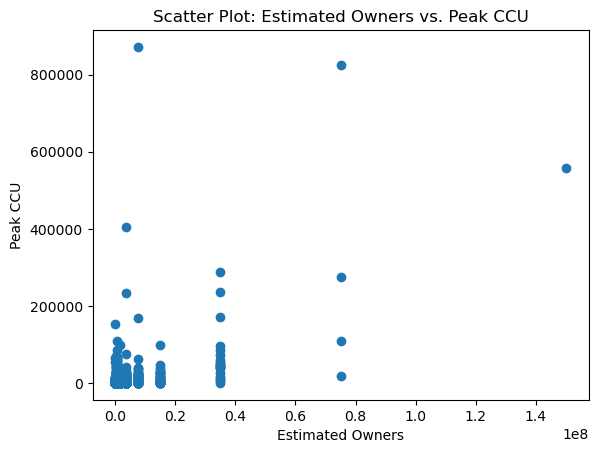

In [5]:
# Scatter plot
plt.scatter(game_df['estimated_owners'], game_df['peak_ccu'])
plt.xlabel('Estimated Owners')
plt.ylabel('Peak CCU')
plt.title('Scatter Plot: Estimated Owners vs. Peak CCU')
plt.show()

Heatmap of the data

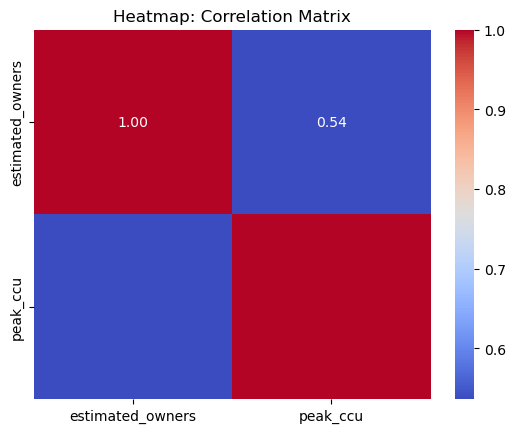

In [6]:
# Create a heatmap
sns.heatmap(game_df[['estimated_owners', 'peak_ccu']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap: Correlation Matrix')
plt.show()

Remove the outlier

In [83]:
# Detect and handle outliers
Q1 = game_df.drop(columns=['appid', 'estimated_owners']).quantile(0.25)
Q3 = game_df.drop(columns=['appid', 'estimated_owners']).quantile(0.75)
IQR = Q3 - Q1

game_df_no_outliers = game_df[~((game_df.drop(columns=['appid', 'estimated_owners']) < (Q1 - 3.5 * IQR)) | (game_df.drop(columns=['appid', 'estimated_owners']) > (Q3 + 3.5 * IQR))).any(axis=1)]
game_df_no_outliers

,appid,estimated_owners,peak_ccu
3,40,7500000.0,2.0
26,659,10000.0,0.0
28,1002,35000.0,1.0
31,1300,150000.0,1.0
32,1313,10000.0,2.0
...,...,...,...
85098,2760980,0.0,0.0
85099,2761170,0.0,0.0
85100,2763480,0.0,0.0
85101,2764930,0.0,0.0


In [76]:
game_df_no_outliers.describe()

,estimated_owners,peak_ccu
count,52021.0,52021.000000
mean,10000.0,0.261798
std,0.0,0.710951
min,10000.0,0.000000
25%,10000.0,0.000000
50%,10000.0,0.000000
75%,10000.0,0.000000
max,10000.0,4.000000


Scatter Plot of the data

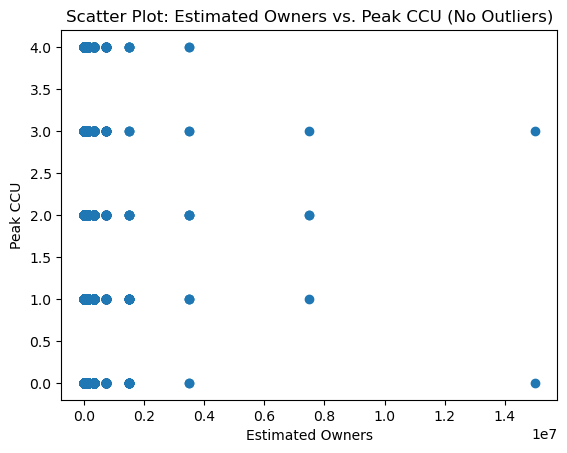

In [84]:
# Scatter plot
plt.scatter(game_df_no_outliers['estimated_owners'], game_df_no_outliers['peak_ccu'])
plt.xlabel('Estimated Owners')
plt.ylabel('Peak CCU')
plt.title('Scatter Plot: Estimated Owners vs. Peak CCU (No Outliers)')
plt.show()

Calculate Pearson Correlation Coefficient and the P_Values

In [85]:
# Calculate Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(game_df_no_outliers['estimated_owners'], game_df_no_outliers['peak_ccu'])
print(f'The Pearson Correlation Coefficient is: {correlation}')
print(f'The Pearson P_Value is: {p_value}')

The Pearson Correlation Coefficient is: 0.1325735473919038
The Pearson P_Value is: 1.3829792168487608e-291


Conduct Hypothesis Test

In [86]:
# Check for statistical significance
if p_value < 0.05:
    print("Reject the null hypothesis as a result. A notable association exists.")
else:
    print("Consequently, the null hypothesis is not rejected. Not a very strong link.")

Reject the null hypothesis as a result. A notable association exists.


# 2. Impact of Platforms on Game Adoption:
- *Theory*: There are more players in games that are accessible on several platforms (Windows, Mac, and Linux).
- *Analysis*: Examine the approximate ownership of games that are accessible across several platforms.

In [12]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT 
                game.estimated_owners, 
                game.peak_ccu, 
                platform.windows, 
                platform.mac, 
                platform.linux
            FROM game
            JOIN platform ON game.appid = platform.appid;'''
    query = text(txt)
    result = connection.execute(query)
    platform_df = pd.DataFrame(result.all())

platform_df

,estimated_owners,peak_ccu,windows,mac,linux
0,15000000.0,13230.0,1,1,1
1,7500000.0,110.0,1,1,1
2,7500000.0,106.0,1,1,1
3,7500000.0,2.0,1,1,1
4,7500000.0,120.0,1,1,1
...,...,...,...,...,...
85098,0.0,0.0,1,0,0
85099,0.0,0.0,1,0,0
85100,0.0,0.0,1,0,0
85101,0.0,0.0,1,0,0


Formulate Hypotheses:
- *Null Hypothesis*: The number of players in games that are accessible on various platform combinations does not significantly differ from one another.
- *Alternative Hypothesis*: Compared to games on a single platform, games available on many platforms have a larger user base.

In [13]:
platform_df.describe()

,estimated_owners,peak_ccu,windows,mac,linux
count,8.510300e+04,85103.000000,85103.000000,85103.000000,85103.000000
mean,8.589215e+04,134.872930,0.999647,0.192625,0.131558
std,1.027754e+06,5403.548851,0.018772,0.394364,0.338012
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.000000e+04,0.000000,1.000000,0.000000,0.000000
50%,1.000000e+04,0.000000,1.000000,0.000000,0.000000
75%,1.000000e+04,1.000000,1.000000,0.000000,0.000000
max,1.500000e+08,872138.000000,1.000000,1.000000,1.000000


Add a Column that counts the games that have multiple platforms

In [14]:
platform_df['Multiple Platforms'] = platform_df[['windows', 'mac', 'linux']].sum(axis=1) > 1
platform_df

,estimated_owners,peak_ccu,windows,mac,linux,Multiple Platforms
0,15000000.0,13230.0,1,1,1,True
1,7500000.0,110.0,1,1,1,True
2,7500000.0,106.0,1,1,1,True
3,7500000.0,2.0,1,1,1,True
4,7500000.0,120.0,1,1,1,True
...,...,...,...,...,...,...
85098,0.0,0.0,1,0,0,False
85099,0.0,0.0,1,0,0,False
85100,0.0,0.0,1,0,0,False
85101,0.0,0.0,1,0,0,False


Boxplot of the data

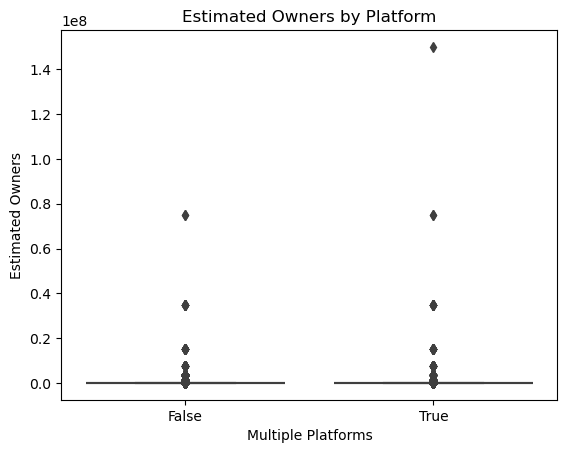

In [15]:
# Boxplot for Multiple Platforms
sns.boxplot(x='Multiple Platforms', y='estimated_owners', data=platform_df)
plt.title('Estimated Owners by Platform')
plt.xlabel('Multiple Platforms')
plt.ylabel('Estimated Owners')
plt.show()

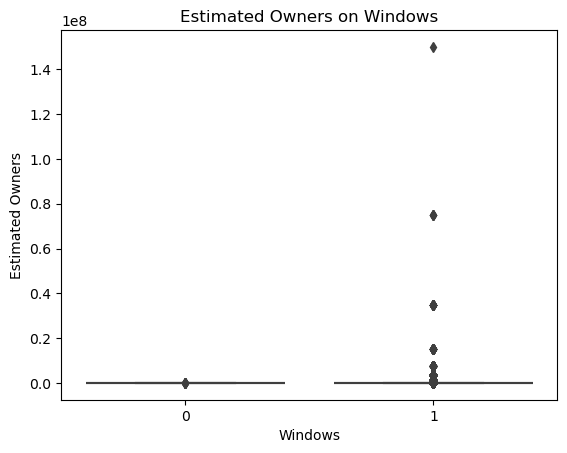

In [16]:
# Boxplot for Windows
sns.boxplot(x='windows', y='estimated_owners', data=platform_df)
plt.title('Estimated Owners on Windows')
plt.xlabel('Windows')
plt.ylabel('Estimated Owners')
plt.show()

Remove the outliers

In [121]:
# Remove outliers
platform_df_no_outliers = platform_df[(platform_df['estimated_owners'] < 3500000.0)]
platform_df_no_outliers

,estimated_owners,peak_ccu,windows,mac,linux,Multiple Platforms
26,10000.0,0.0,1,1,1,True
28,35000.0,1.0,1,0,0,False
29,750000.0,16.0,1,1,1,True
31,150000.0,1.0,1,0,0,False
32,10000.0,2.0,1,0,0,False
...,...,...,...,...,...,...
85098,0.0,0.0,1,0,0,False
85099,0.0,0.0,1,0,0,False
85100,0.0,0.0,1,0,0,False
85101,0.0,0.0,1,0,0,False


In [122]:
platform_df_no_outliers.describe()

,estimated_owners,peak_ccu,windows,mac,linux
count,8.461800e+04,84618.000000,84618.000000,84618.000000,84618.000000
mean,4.388168e+04,52.102413,0.999645,0.191378,0.130386
std,1.488982e+05,1255.552298,0.018826,0.393388,0.336730
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.000000e+04,0.000000,1.000000,0.000000,0.000000
50%,1.000000e+04,0.000000,1.000000,0.000000,0.000000
75%,1.000000e+04,1.000000,1.000000,0.000000,0.000000
max,1.500000e+06,153726.000000,1.000000,1.000000,1.000000


BoxPlot of the data

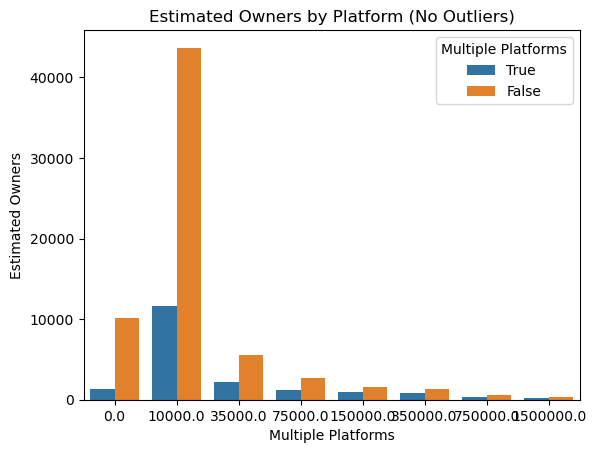

In [123]:
# Boxplot without outliers
sns.countplot(x='estimated_owners', data=platform_df_no_outliers, hue=platform_df_no_outliers['Multiple Platforms'].astype('str'))
plt.title('Estimated Owners by Platform (No Outliers)')
plt.xlabel('Multiple Platforms')
plt.ylabel('Estimated Owners')
plt.show()

Calculate T-Test Statistic and P_Values

In [218]:
# T-test for Windows vs. Multiple Platforms
t_statistic, p_value_ttest = ttest_ind(platform_df_no_outliers['estimated_owners'][platform_df_no_outliers['windows'].eq(1)],
                        platform_df_no_outliers['estimated_owners'][platform_df_no_outliers['Multiple Platforms'].eq(True)],
                        equal_var=False)  # Assuming unequal variances
print(f'The Pearson Correlation Coefficient is: {correlation}')
print(f'The Pearson P_Value is: {p_value}')

The Pearson Correlation Coefficient is: 0.07572335077691224
The Pearson P_Value is: 2.5597907880365592e-08


Conduct hypothesis testing

In [219]:
# Check for statistical significance
if p_value_ttest < 0.05:
    print("Reject the null hypothesis as a result. The player base on Windows and Multiple Platforms differs significantly.")
else:
    print("Consequently, the null hypothesis is not rejected. There isn't much of a player base difference between Windows and several platforms.")

Reject the null hypothesis as a result. The player base on Windows and Multiple Platforms differs significantly.


# 3. Metacritic Score and User Feedback:
- *Theory*: The user and Metacritic scores are positively correlated.
- *Analysis*: Comparison of the user_score and metacritic_score correlation.

In [22]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT 
                metacritic.metacritic_score, 
                user_feedback.user_score
            FROM metacritic
            JOIN user_feedback ON metacritic.appid = user_feedback.appid;'''
    query = text(txt)
    result = connection.execute(query)
    user_score_df = pd.DataFrame(result.all())

user_score_df

,metacritic_score,user_score
0,88.0,0.0
1,0.0,0.0
2,79.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
85098,0.0,0.0
85099,0.0,0.0
85100,0.0,0.0
85101,0.0,0.0


Formulate Hypotheses:
- *Null Hypothesis*: There is no discernible relationship (ρ = 0) between user and Metacritic scores.
- *Alternative Hypothesis*: User scores and Metacritic scores have a substantial positive connection (ρ > 0).

In [23]:
user_score_df.describe()

,metacritic_score,user_score
count,85103.000000,85103.000000
mean,3.348366,0.039822
std,15.421471,1.791013
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,97.000000,100.000000


Scatter Plot of the data

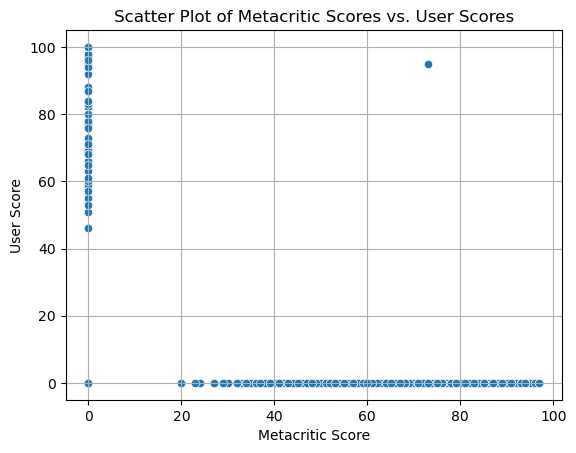

In [24]:
# Scatter Plot
sns.scatterplot(x='metacritic_score', y='user_score', data=user_score_df)
plt.title('Scatter Plot of Metacritic Scores vs. User Scores')
plt.xlabel('Metacritic Score')
plt.ylabel('User Score')
plt.grid(True)
plt.show()

c:\Users\lualg\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\lualg\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


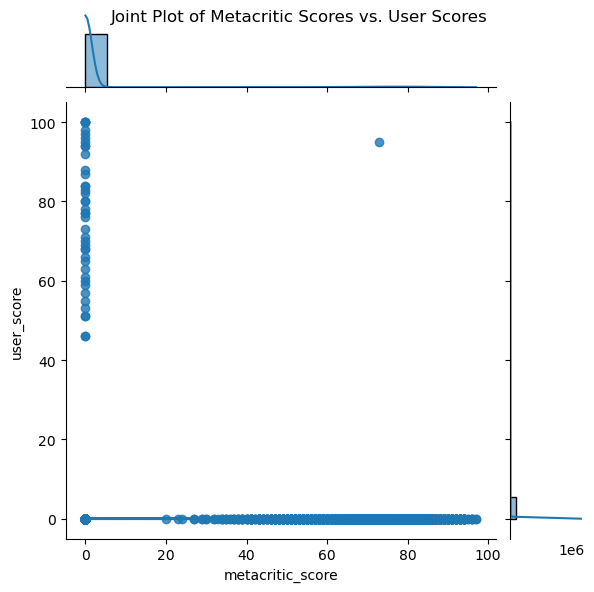

In [25]:
# Joint Plot or Regression Plot
sns.jointplot(x='metacritic_score', y='user_score', data=user_score_df, kind='reg')
plt.suptitle('Joint Plot of Metacritic Scores vs. User Scores')
plt.show()

Remove the outliers

In [177]:
# Remove outliers
user_score_df_no_outliers = user_score_df[(user_score_df['user_score'] > 0.0)]
user_score_df_no_outliers

,metacritic_score,user_score
6298,0.0,59.0
10020,0.0,100.0
10913,0.0,51.0
12972,0.0,82.0
13145,73.0,95.0
14240,0.0,51.0
14383,0.0,88.0
14781,0.0,46.0
14960,0.0,83.0
15962,0.0,95.0


In [178]:
user_score_df_no_outliers.describe()

,metacritic_score,user_score
count,44.000000,44.000000
mean,1.659091,77.022727
std,11.005164,16.767200
min,0.000000,46.000000
25%,0.000000,64.500000
50%,0.000000,77.500000
75%,0.000000,94.000000
max,73.000000,100.000000


Scatter Plot of the data

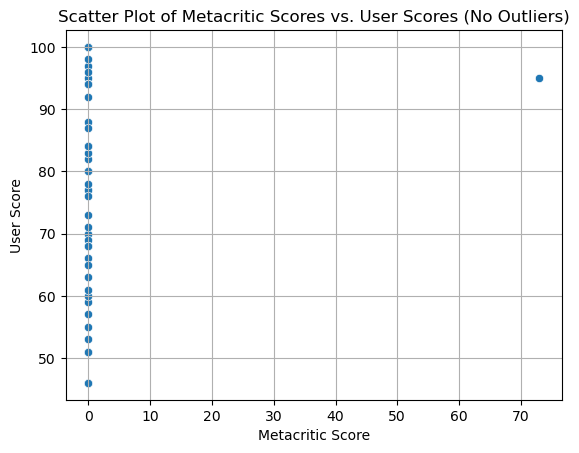

In [179]:
# Scatter Plot
sns.scatterplot(x='metacritic_score', y='user_score', data=user_score_df_no_outliers)
plt.title('Scatter Plot of Metacritic Scores vs. User Scores (No Outliers)')
plt.xlabel('Metacritic Score')
plt.ylabel('User Score')
plt.grid(True)
plt.show()

c:\Users\lualg\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\lualg\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


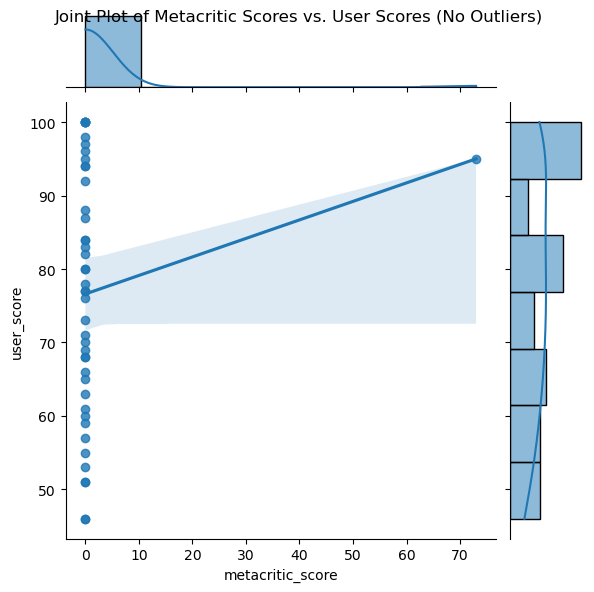

In [180]:
# Joint Plot or Regression Plot
sns.jointplot(x='metacritic_score', y='user_score', data=user_score_df_no_outliers, kind='reg')
plt.suptitle('Joint Plot of Metacritic Scores vs. User Scores (No Outliers)')
plt.show()

Calculate Spearman Correlation Coefficient and the P_Values

In [181]:
# Calculate Spearman correlation coefficient and p-value
correlation, p_value = spearmanr(user_score_df_no_outliers['metacritic_score'], user_score_df_no_outliers['user_score'])
print(f'The Spearman Correlation Coefficient is: {correlation}')
print(f'The Spearman P_Value is: {p_value}')

The Spearman Correlation Coefficient is: 0.15627451709728454
The Spearman P_Value is: 0.31105698509329804


Conduct Hypotesis testing

In [182]:
# Check for statistical significance
if p_value < 0.05:
    print("Reject the null hypothesis as a result. A notable positive association is present.")
else:
    print("Consequently, the null hypothesis is not rejected. Not a very strong link.")

Consequently, the null hypothesis is not rejected. Not a very strong link.


# 4. Effect of Game Features on Reviews:
- *Theory*: There are more achievements in games that have received favorable reviews.
- *Analysis*: Examine the typical quantity of achievements in games that have both favorable and unfavorable evaluations.

In [32]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT 
                positive,
                negative, 
                achievements
            FROM user_feedback;'''
    query = text(txt)
    result = connection.execute(query)
    feedback_df = pd.DataFrame(result.all())

feedback_df

,positive,negative,achievements
0,198387.0,5135.0,0.0
1,5677.0,923.0,0.0
2,5179.0,566.0,0.0
3,1929.0,428.0,0.0
4,14333.0,718.0,0.0
...,...,...,...
85098,0.0,0.0,0.0
85099,0.0,0.0,0.0
85100,0.0,0.0,0.0
85101,0.0,0.0,0.0


Formulate Hypotheses:
- *Null Hypothesis*: The number of accomplishments and the number of good evaluations do not significantly correlate.
- *Alternative Hypothesis*: There are more achievements in games that have received positive reviews.

In [33]:
feedback_df.describe()

,positive,negative,achievements
count,8.510300e+04,85103.000000,85103.000000
mean,9.585609e+02,159.772570,19.859394
std,2.435920e+04,4574.583903,171.446874
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000
50%,7.000000e+00,2.000000,0.000000
75%,4.500000e+01,14.000000,18.000000
max,5.764420e+06,895978.000000,9821.000000


In [34]:
# Assuming df is your DataFrame with columns positive, negative, and achievements
correlation_matrix = feedback_df[['positive', 'negative', 'achievements']].corr()
correlation_matrix

,positive,negative,achievements
positive,1.000000,0.784009,0.013558
negative,0.784009,1.000000,0.009872
achievements,0.013558,0.009872,1.000000


Heatmap Correlation plot

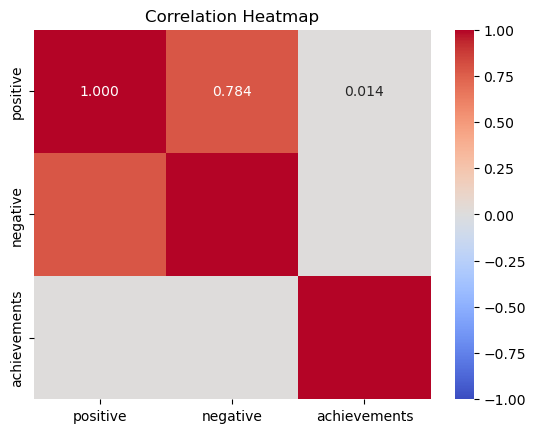

In [35]:
# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

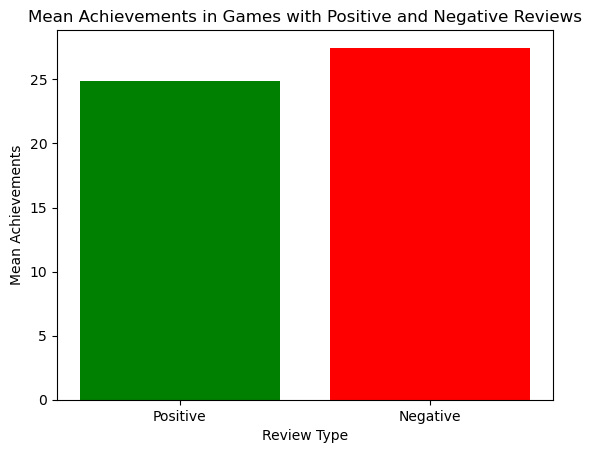

In [36]:
# Bar Plot for Mean Achievements by Review Type
review_types = ['Positive', 'Negative']
mean_achievements = [feedback_df[feedback_df['positive'] > 0]['achievements'].mean(),
                     feedback_df[feedback_df['negative'] > 0]['achievements'].mean()]

plt.bar(review_types, mean_achievements, color=['green', 'red'])
plt.title('Mean Achievements in Games with Positive and Negative Reviews')
plt.xlabel('Review Type')
plt.ylabel('Mean Achievements')
plt.show()

Remove the outliers

In [37]:
# Calculate the IQR for 'user_score'
Q1 = feedback_df['achievements'].quantile(0.25)
Q3 = feedback_df['achievements'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
feedback_df_no_outliers = feedback_df[(feedback_df['achievements'] >= lower_bound) & (feedback_df['achievements'] <= upper_bound)]
feedback_df_no_outliers

,positive,negative,achievements
0,198387.0,5135.0,0.0
1,5677.0,923.0,0.0
2,5179.0,566.0,0.0
3,1929.0,428.0,0.0
4,14333.0,718.0,0.0
...,...,...,...
85098,0.0,0.0,0.0
85099,0.0,0.0,0.0
85100,0.0,0.0,0.0
85101,0.0,0.0,0.0


In [38]:
feedback_df_no_outliers.describe()

,positive,negative,achievements
count,7.907700e+04,79077.000000,79077.000000
mean,5.336311e+02,101.042794,7.986924
std,1.077865e+04,3631.996655,11.491486
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000
50%,6.000000e+00,1.000000,0.000000
75%,3.600000e+01,11.000000,14.000000
max,1.477150e+06,895978.000000,45.000000


In [39]:
# Assuming df is your DataFrame with columns positive, negative, and achievements
correlation_matrix_no_outliers = feedback_df_no_outliers[['positive', 'negative', 'achievements']].corr()
correlation_matrix_no_outliers

,positive,negative,achievements
positive,1.000000,0.698476,0.040840
negative,0.698476,1.000000,0.024474
achievements,0.040840,0.024474,1.000000


Heatmap Correlation plot

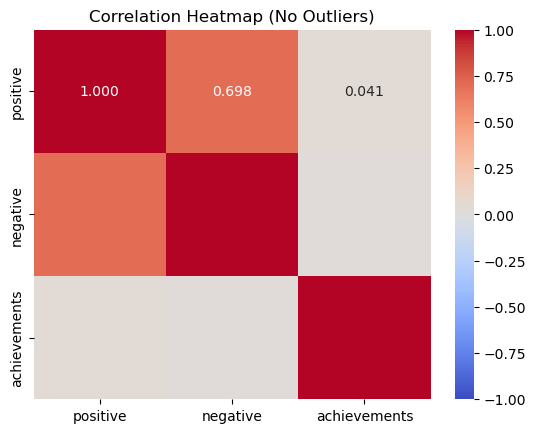

In [40]:
# Create a heatmap
sns.heatmap(correlation_matrix_no_outliers, annot=True, cmap='coolwarm', fmt='.3f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (No Outliers)')
plt.show()

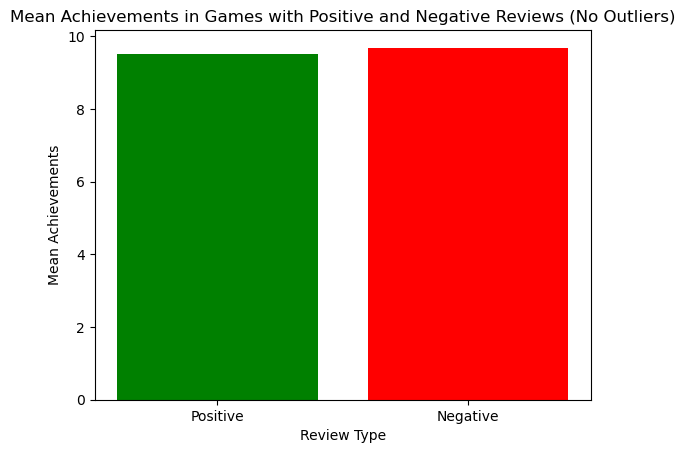

In [41]:
# Bar Plot for Mean Achievements by Review Type
review_types_no_outliers = ['Positive', 'Negative']
mean_achievements_no_outliers = [feedback_df_no_outliers[feedback_df_no_outliers['positive'] > 0]['achievements'].mean(),
                     feedback_df_no_outliers[feedback_df_no_outliers['negative'] > 0]['achievements'].mean()]

plt.bar(review_types_no_outliers, mean_achievements_no_outliers, color=['green', 'red'])
plt.title('Mean Achievements in Games with Positive and Negative Reviews (No Outliers)')
plt.xlabel('Review Type')
plt.ylabel('Mean Achievements')
plt.show()

Calculate Pearson Correlation Coefficient and the P_Values

In [183]:
# Calculating Pearson Correlation coefficient and P_value
correlation, p_value = pearsonr(feedback_df_no_outliers['positive'], feedback_df_no_outliers['achievements'])
print(f'The Pearson Correlation Coefficient is: {correlation}')
print(f'The Pearson P_Value is: {p_value}')

The Pearson Correlation Coefficient is: 0.04083993994168466
The Pearson P_Value is: 1.4973043696739038e-30


Conduct Hypotesis testing

In [184]:
# Check for statistical significance
if p_value < 0.05:
    print("The null hypothesis is rejected. A noteworthy link exists.")
else:
    print("The null hypothesis is not successfully rejected. Not a big relationship.")

The null hypothesis is rejected. A noteworthy link exists.


# 5. Playtime Patterns:
- *Theory*: Games with longer median playtimes also have longer average playtimes.
- *Analysis*: Comparison of average_playtime_forever and median_playtime_forever by correlation analysis.

In [44]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT
                appid,
                average_playtime_forever,
                median_playtime_forever
            FROM
                playtime;'''
    query = text(txt)
    result = connection.execute(query)
    playtime_df = pd.DataFrame(result.all())

playtime_df

,appid,average_playtime_forever,median_playtime_forever
0,10,10524.0,228.0
1,20,143.0,23.0
2,30,1397.0,27.0
3,40,945.0,10.0
4,50,214.0,66.0
...,...,...,...
85098,2760980,0.0,0.0
85099,2761170,0.0,0.0
85100,2763480,0.0,0.0
85101,2764930,0.0,0.0


Formulate Hypotheses:
- *Null Hypothesis*: The average playtime and median playtime do not significantly correlate.
- *Alternative Hypothesis*: Games with longer median playtimes also have longer average playtimes over time.

In [45]:
playtime_df.describe()

,appid,average_playtime_forever,median_playtime_forever
count,8.510300e+04,85103.000000,85103.000000
mean,1.355681e+06,104.729681,93.316029
std,6.949952e+05,1142.447517,1510.732101
min,1.000000e+01,0.000000,0.000000
25%,7.723900e+05,0.000000,0.000000
50%,1.331540e+06,0.000000,0.000000
75%,1.918415e+06,0.000000,0.000000
max,2.765800e+06,145727.000000,208473.000000


Boxplot of the data

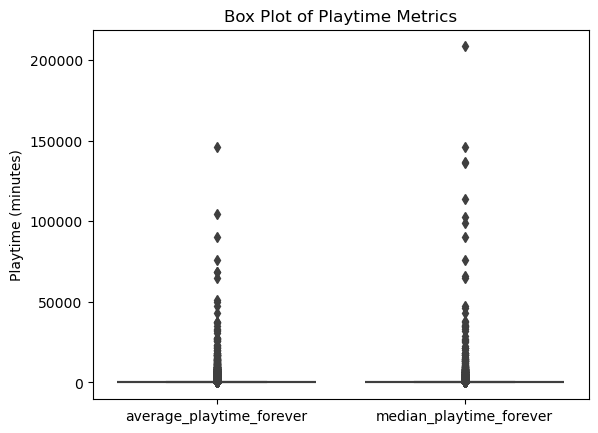

In [46]:
# Box Plot
sns.boxplot(data=playtime_df[['average_playtime_forever', 'median_playtime_forever']])
plt.title('Box Plot of Playtime Metrics')
plt.ylabel('Playtime (minutes)')
plt.show()

Remove the Outliers

In [207]:
# Remove outliers
playtime_df_no_outliers = playtime_df[(playtime_df['average_playtime_forever'] > 0.0)]
playtime_df_no_outliers

,appid,average_playtime_forever,median_playtime_forever
0,10,10524.0,228.0
1,20,143.0,23.0
2,30,1397.0,27.0
3,40,945.0,10.0
4,50,214.0,66.0
...,...,...,...
82386,2569170,360.0,360.0
82862,2593900,134.0,134.0
82959,2599300,132.0,132.0
83580,2635340,3.0,3.0


In [208]:
playtime_df_no_outliers.describe()

,appid,average_playtime_forever,median_playtime_forever
count,1.491100e+04,14911.000000,14911.000000
mean,6.504531e+05,597.733888,532.591644
std,4.489929e+05,2674.868934,3576.703590
min,1.000000e+01,1.000000,1.000000
25%,3.401250e+05,73.000000,67.000000
50%,5.256200e+05,211.000000,209.000000
75%,8.654850e+05,401.000000,369.000000
max,2.661210e+06,145727.000000,208473.000000


BoxPlot of the data

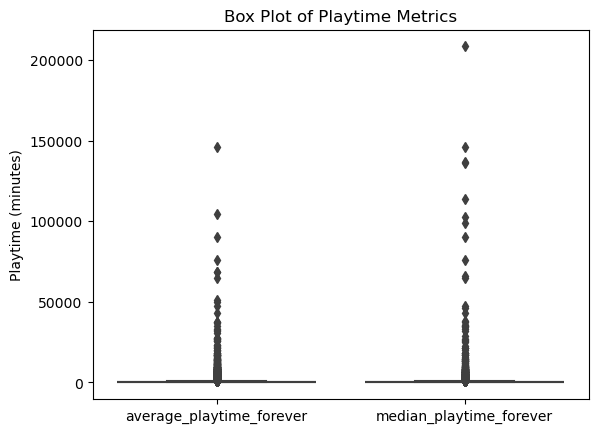

In [209]:
# Box Plot
sns.boxplot(data=playtime_df_no_outliers[['average_playtime_forever', 'median_playtime_forever']])
plt.title('Box Plot of Playtime Metrics')
plt.ylabel('Playtime (minutes)')
plt.show()

Calculate Pearson Correlation Coefficient and the P_Values

In [210]:
# Perform Pearson correlation test and P_value
correlation, p_value = pearsonr(playtime_df_no_outliers['average_playtime_forever'], playtime_df_no_outliers['median_playtime_forever'])
print(f'The Pearson Correlation Coefficient is: {correlation}')
print(f'The Pearson P_Value is: {p_value}')

The Pearson Correlation Coefficient is: 0.8832070968390796
The Pearson P_Value is: 0.0


Conduct Hypotesis testing

In [211]:
# Check for statistical significance
if p_value < 0.05:
    print("Dismiss the null hypothesis. A noteworthy link exists.")
else:
    print("Reject the null hypothesis ineffectively. Not a big relationship.")

Dismiss the null hypothesis. A noteworthy link exists.


# 6. Price Influence
- *Theory*: User scores for games are typically higher when they are more expensive.
- *Analysis*: Examine average user scores for various price ranges of games.

In [52]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT 
                game.appid, 
                game.name, 
                game.price, 
                user_feedback.user_score
            FROM game
            JOIN user_feedback ON game.appid = user_feedback.appid;'''
    query = text(txt)
    result = connection.execute(query)
    price_df = pd.DataFrame(result.all())

price_df

,appid,name,price,user_score
0,10,Counter-Strike,9.99,0.0
1,20,Team Fortress Classic,4.99,0.0
2,30,Day of Defeat,4.99,0.0
3,40,Deathmatch Classic,4.99,0.0
4,50,Half-Life: Opposing Force,4.99,0.0
...,...,...,...,...
85098,2760980,Z Ops: Campus Playtest,0.00,0.0
85099,2761170,Stay Playtest,0.00,0.0
85100,2763480,生物召唤：对决时刻 Playtest,0.00,0.0
85101,2764930,Cryptis Playtest,0.00,0.0


Formulate Hypotheses:
- *Null Hypothesis*: User scores and game pricing do not significantly correlate.
- *Alternative Hypothesis*: User scores significantly positively correlate with games that cost more money.

In [53]:
price_df.describe()

,appid,price,user_score
count,8.510300e+04,85103.000000,85103.000000
mean,1.355681e+06,7.193703,0.039822
std,6.949952e+05,12.362478,1.791013
min,1.000000e+01,0.000000,0.000000
25%,7.723900e+05,0.990000,0.000000
50%,1.331540e+06,4.490000,0.000000
75%,1.918415e+06,9.990000,0.000000
max,2.765800e+06,999.980000,100.000000


Scatter Plot of the data

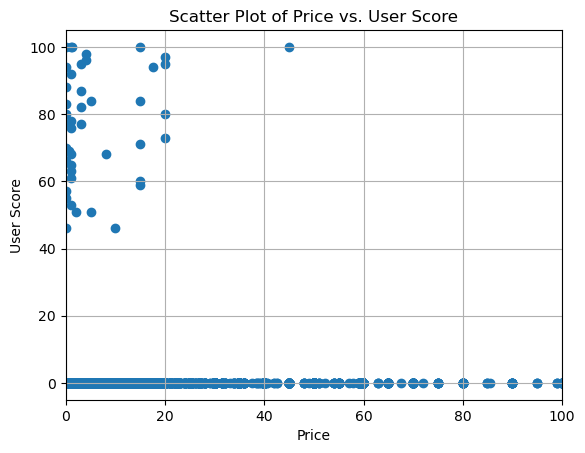

In [54]:
# SCatterplot
plt.scatter(price_df['price'], price_df['user_score'])
plt.xlim((0,100))
plt.title('Scatter Plot of Price vs. User Score')
plt.xlabel('Price')
plt.ylabel('User Score')
plt.grid(True)
plt.show()

Remove the Outliers

In [212]:
# Calculate the IQR for 'price'
Q1 = price_df['price'].quantile(0.25)
Q3 = price_df['price'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
price_df_no_outliers = price_df[(price_df['price'] >= lower_bound) & (price_df['price'] <= upper_bound)]
price_df_no_outliers

,appid,name,price,user_score
0,10,Counter-Strike,9.99,0.0
1,20,Team Fortress Classic,4.99,0.0
2,30,Day of Defeat,4.99,0.0
3,40,Deathmatch Classic,4.99,0.0
4,50,Half-Life: Opposing Force,4.99,0.0
...,...,...,...,...
85098,2760980,Z Ops: Campus Playtest,0.00,0.0
85099,2761170,Stay Playtest,0.00,0.0
85100,2763480,生物召唤：对决时刻 Playtest,0.00,0.0
85101,2764930,Cryptis Playtest,0.00,0.0


In [56]:
price_df_no_outliers.describe()

,appid,price,user_score
count,8.107400e+04,81074.000000,81074.000000
mean,1.359753e+06,5.518833,0.040568
std,6.958384e+05,5.566072,1.801059
min,1.000000e+01,0.000000,0.000000
25%,7.749832e+05,0.990000,0.000000
50%,1.337655e+06,3.990000,0.000000
75%,1.924738e+06,9.090000,0.000000
max,2.765800e+06,23.390000,100.000000


Scatter Plot of the data

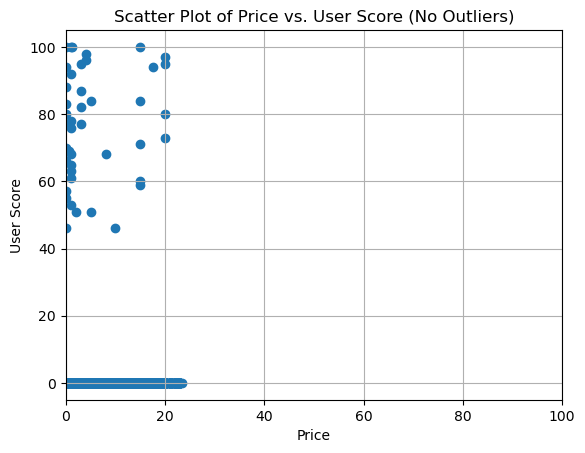

In [57]:
# SCatterplot
plt.scatter(price_df_no_outliers['price'], price_df_no_outliers['user_score'])
plt.xlim((0, 100))
plt.title('Scatter Plot of Price vs. User Score (No Outliers)')
plt.xlabel('Price')
plt.ylabel('User Score')
plt.grid(True)
plt.show()

Calculate Pearson Correlation Coefficient and the P_Values

In [213]:
# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(price_df_no_outliers['price'], price_df_no_outliers['user_score'])
print(f'The Pearson Correlation Coefficient is: {correlation}')
print(f'The Pearson P_Value is: {p_value}')

The Pearson Correlation Coefficient is: 0.0004629139202071626
The Pearson P_Value is: 0.8951379356548903


Conduct Hypotesis testing

In [214]:
# Check for statistical significance
if p_value < 0.05:
    print("The null hypothesis is rejected. A notable association exists.")
else:
    print("The null hypothesis is not successfully rejected. Not a very strong link.")

The null hypothesis is not successfully rejected. Not a very strong link.


# 7. Categorization Impact on Popularity
- *Theory*: Owner estimates of games tend to be higher for those with more categories and genres.
- *Analysis*: Look at the connection between estimated owners and the number of categories/genres.

In [60]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT 
                game.appid, 
                game.estimated_owners, 
                categorization.categories, 
                categorization.genres
            FROM game
            JOIN categorization ON game.appid = categorization.appid;'''
    query = text(txt)
    result = connection.execute(query)
    category_df = pd.DataFrame(result.all())

category_df

,appid,estimated_owners,categories,genres
0,10,15000000.0,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action
1,20,7500000.0,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action
2,30,7500000.0,"Multi-player,Valve Anti-Cheat enabled",Action
3,40,7500000.0,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action
4,50,7500000.0,"Single-player,Multi-player,Valve Anti-Cheat en...",Action
...,...,...,...,...
85098,2760980,0.0,unknown,unknown
85099,2761170,0.0,unknown,unknown
85100,2763480,0.0,unknown,unknown
85101,2764930,0.0,unknown,unknown


Formulate Hypotheses:
- *Null Hypothesis*: The number of categories/genres and estimated owners do not significantly correlate.
- *Alternative Hypothesis*: The estimated owners of games tend to be higher when there are more categories and genres.

In [61]:
category_df.describe()

,appid,estimated_owners
count,8.510300e+04,8.510300e+04
mean,1.355681e+06,8.589215e+04
std,6.949952e+05,1.027754e+06
min,1.000000e+01,0.000000e+00
25%,7.723900e+05,1.000000e+04
50%,1.331540e+06,1.000000e+04
75%,1.918415e+06,1.000000e+04
max,2.765800e+06,1.500000e+08


Function to count the number of genres

In [62]:
# Create a function to count the number of categories and genres
def count_categories_genres(row):
    # Split the 'categories' and 'genres' strings into lists
    categories_list = row['categories'].split(',') if not pd.isnull(row['categories']) else []
    genres_list = row['genres'].split(',') if not pd.isnull(row['genres']) else []
    
    # Count the number of unique categories and genres
    num_categories = len(set(categories_list))
    num_genres = len(set(genres_list))
    
    # Return the total count
    return num_categories + num_genres

Add a new column to the dataset

In [63]:
# Apply the function to create the new column
category_df['num_categories_genres'] = category_df.apply(count_categories_genres, axis=1)
category_df

,appid,estimated_owners,categories,genres,num_categories_genres
0,10,15000000.0,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action,6
1,20,7500000.0,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action,7
2,30,7500000.0,"Multi-player,Valve Anti-Cheat enabled",Action,3
3,40,7500000.0,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action,7
4,50,7500000.0,"Single-player,Multi-player,Valve Anti-Cheat en...",Action,5
...,...,...,...,...,...
85098,2760980,0.0,unknown,unknown,2
85099,2761170,0.0,unknown,unknown,2
85100,2763480,0.0,unknown,unknown,2
85101,2764930,0.0,unknown,unknown,2


Scatter Plot of the data

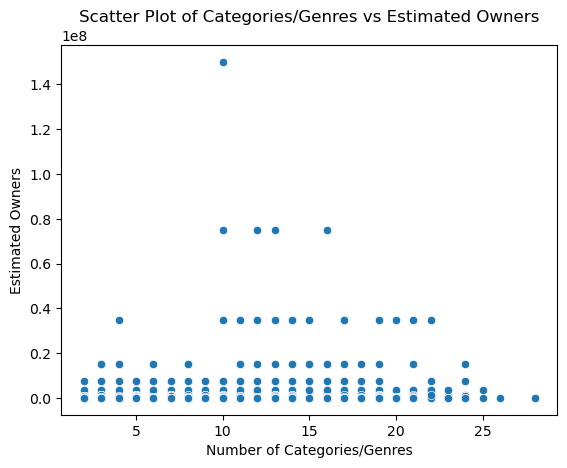

In [64]:
# Scatter plot
sns.scatterplot(x='num_categories_genres', y='estimated_owners', data=category_df)
plt.title('Scatter Plot of Categories/Genres vs Estimated Owners')
plt.xlabel('Number of Categories/Genres')
plt.ylabel('Estimated Owners')
plt.show()

In [65]:
# Calculate the IQR for 'num_categories_genres'
Q1 = category_df['num_categories_genres'].quantile(0.25)
Q3 = category_df['num_categories_genres'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
category_df_no_outliers = category_df[(category_df['num_categories_genres'] < lower_bound) | (category_df['num_categories_genres'] > upper_bound)]
category_df_no_outliers

,appid,estimated_owners,categories,genres,num_categories_genres
20,440,75000000.0,"Multi-player,Cross-Platform Multiplayer,Steam ...","Action,Free to Play",16
21,500,3500000.0,"Single-player,Multi-player,Co-op,Steam Achieve...",Action,15
22,550,35000000.0,"Single-player,Multi-player,PvP,Online PvP,Co-o...",Action,21
24,620,15000000.0,"Single-player,Multi-player,Co-op,Online Co-op,...","Action,Adventure",21
26,659,10000.0,"Single-player,Multi-player,Co-op,Online Co-op,...","Action,Adventure",21
...,...,...,...,...,...
84660,2703250,0.0,"Single-player,Steam Achievements,Steam Leaderb...","Action,Adventure,Casual,Indie,Racing,RPG,Simul...",12
84661,2703260,0.0,"Single-player,Steam Achievements,Steam Leaderb...","Action,Adventure,Casual,Indie,Racing,RPG,Simul...",12
84662,2703270,0.0,"Single-player,Steam Achievements,Steam Leaderb...","Action,Adventure,Casual,Indie,Racing,RPG,Simul...",12
84663,2703280,0.0,"Single-player,Steam Achievements,Steam Leaderb...","Action,Adventure,Casual,Indie,Racing,RPG,Simul...",12


In [66]:
category_df_no_outliers.describe()

,appid,estimated_owners,num_categories_genres
count,5.396000e+03,5.396000e+03,5396.000000
mean,1.039100e+06,4.458256e+05,13.883988
std,6.368662e+05,2.914778e+06,2.112296
min,4.400000e+02,0.000000e+00,12.000000
25%,5.129750e+05,1.000000e+04,12.000000
50%,8.892100e+05,1.000000e+04,13.000000
75%,1.456482e+06,7.500000e+04,15.000000
max,2.715390e+06,7.500000e+07,28.000000


Scatter Plot of the data

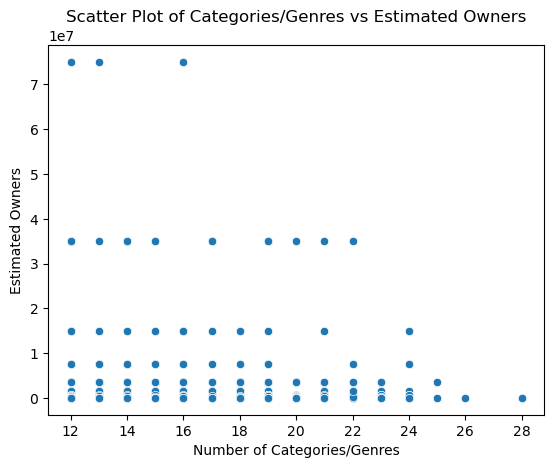

In [67]:
# Scatter plot
sns.scatterplot(x='num_categories_genres', y='estimated_owners', data=category_df_no_outliers)
plt.title('Scatter Plot of Categories/Genres vs Estimated Owners')
plt.xlabel('Number of Categories/Genres')
plt.ylabel('Estimated Owners')
plt.show()

Calculate Pearson Correlation Coefficient and the P_Values

In [215]:
# Calculate the Correlation Coefficient and the P_Values
correlation, p_value = pearsonr(category_df_no_outliers['num_categories_genres'], category_df_no_outliers['estimated_owners'])
print(f'The Pearson Correlation Coefficient is: {correlation}')
print(f'The Pearson P_Value is: {p_value}')

The Pearson Correlation Coefficient is: 0.07572335077691224
The Pearson P_Value is: 2.5597907880365592e-08


Conduct Hypotesis testing

In [216]:
if p_value < 0.05:
    print("Dismiss the null hypothesis. There's a noteworthy association.")
else:
    print("Reject the null hypothesis ineffectively. Not a very strong link.")

Dismiss the null hypothesis. There's a noteworthy association.
